In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from utils import modeling_utils, data_processing

%reload_ext autoreload
%autoreload 2

In [2]:
# tournaments to evaluate
major_regions = ['LPL', 'LCK', 'LEC', 'LCS', 'MSI', 'WCS', 'NA LCS', 'EU LCS', 'KeSPA']
# droping columns that i find no use for at least for now
drop_irrelevant = [
    'gameid', 'datacompleteness', 'url', 'split', 'playoffs', 
    'date', 'game', 'patch', 'participantid', 'position', 
    'playerid', 'teamname', 'teamid', 'champion', 'ban1', 
    'ban2', 'ban3', 'ban4', 'ban5', ]

# problematic columns, i think some of them can be added from column 'pos' == 'team' 
# but still there is problem with relevant LPL statistics 
drop_large_nulls = [
    'firstdragon', 'dragons', 'opp_dragons', 'elementaldrakes', 
    'opp_elementaldrakes', 'infernals', 'mountains', 'clouds', 
    'oceans', 'chemtechs', 'hextechs', 'dragons (type unknown)', 
    'elders', 'opp_elders', 'firstherald', 'heralds', 
    'opp_heralds', 'firstbaron', 'inhibitors', 'opp_inhibitors',
    'firsttower', 'towers', 'opp_towers', 'firstmidtower', 'firsttothreetowers', 'turretplates', 'opp_turretplates', 'gspd']

# interesting game start to evaluate
game_stats = ['kills', 'deaths', 'assists', 'dpm', 'damageshare', 'wardsplaced', 'wardskilled', 'minionkills', 'monsterkillsownjungle', 'monsterkillsenemyjungle']

df = data_processing.prepare_data_leesin(major_regions, drop_irrelevant, drop_large_nulls)
# time binning


# df = df.assign(game_length_bins=lambda x: pd.cut(x['gamelength'], bins, labels=labels))

/home/quak/development/lol_stats/src/utils/data_processing.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + file_name)


# Modeling

- My idea is to build a model that will allow to explain the probability of victory given some of the collected post game statistics.

In [3]:
x_features = ['gamelength', 'side', 'kills', 'deaths', 'assists', 'wardsplaced', 'wardskilled', 'minionkills', 'dpm', 'damageshare', #'monsterkillsownjungle', 'monsterkillsenemyjungle', 'teamkills', 'teamdeaths', 
              ]
target = ['result']

df[x_features].isna().sum()

gamelength     0
side           0
kills          0
deaths         0
assists        0
wardsplaced    8
wardskilled    8
minionkills    9
dpm            8
damageshare    8
dtype: int64

In [4]:
bin_features = ['gamelength']
ohe_features = ['side']
std_features = ['dpm', 'damageshare']
norm_features = [
    'kills', 'deaths', 'assists',  'wardsplaced', 
    'wardskilled', 'minionkills', ]# 'monsterkillsownjungle', 'monsterkillsenemyjungle', 'teamkills', 'teamdeaths',]

preprocessor = modeling_utils.create_preprocessor(bin_features, ohe_features, std_features, norm_features)

In [5]:
from sklearn.model_selection import train_test_split
X, y = df.drop(columns=target), df[target].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

model_pipe = Pipeline([
    ('data_prep', preprocessor), 
    ('model', LogisticRegression(max_iter=1000))
])
param_grid = {
    'model__C': np.linspace(0.01, 3, 10)
}

search = (
    GridSearchCV(model_pipe, param_grid, scoring='roc_auc', n_jobs=6)
    .fit(X_train, y_train)
)

print(f'Best auc score: {search.best_score_}')

Best auc score: 0.9593059761235597


## Evaluation

              precision    recall  f1-score   support

        Loss       0.91      0.87      0.89       231
         Win       0.88      0.92      0.90       229

    accuracy                           0.89       460
   macro avg       0.89      0.89      0.89       460
weighted avg       0.89      0.89      0.89       460



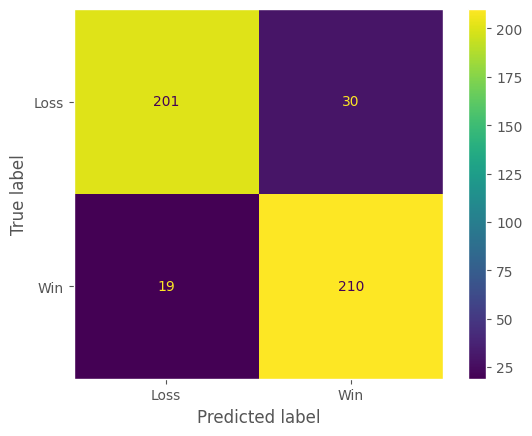

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

model = search.best_estimator_
y_pred = model.predict(X_test)

pred_lab = ['Loss', 'Win']
print(classification_report(y_test, y_pred, target_names=pred_lab))


cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pred_lab)
disp.plot(), plt.grid(False)
plt.show()

Best threshold: 0.483, fpr: 0.134, tpr: 0.926


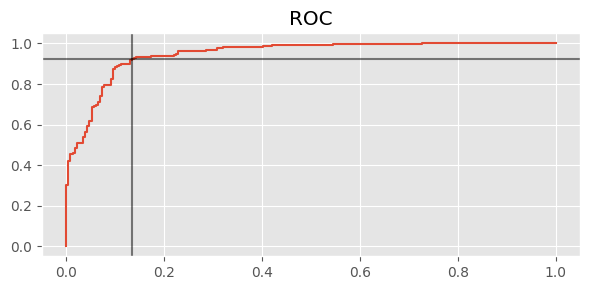

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1], pos_label=1)
gmeans = np.sqrt(tpr * (1 - fpr))
idx = np.argmax(gmeans)
print(f'Best threshold: {round(thresholds[idx], 3)}, fpr: {round(fpr[idx], 3)}, tpr: {round(tpr[idx], 3)}')

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(fpr, tpr), ax.axvline(fpr[idx], color='k', alpha=.5), ax.axhline(tpr[idx], color='k', alpha=.5)
ax.set_title('ROC')
fig.tight_layout()

### Values of coefficients

In [ ]:
x = {x: round(y, 3) for x, y in zip(model[0].get_feature_names_out(), model[-1].coef_[0])}
x['intercept'] = model[-1].intercept_
coefs = pd.DataFrame(x).T
coefs.columns = ['coef']
coefs.sort_values('coef')

,coef
normalizing__deaths,-11.393000
normalizing__minionkills,-1.427000
intercept,-1.181701
stdizing__damageshare,-0.932000
bining__gamelength,-0.317000
onehotencoding__side_Red,-0.167000
normalizing__missingindicator_wardsplaced,0.001000
normalizing__missingindicator_wardskilled,0.001000
stdizing__missingindicator_dpm,0.013000
stdizing__missingindicator_damageshare,0.013000


# Progress

- Currently im trying to obtain some real data from currently on going matches. Concept is to for example get data in 5 minute intervals, and predict the probabiltiy of win based on these informations. 
- Not sure what to expect from this type of model since we only observe post game statistics, and the model is very **confident** about the outcome, so I'm worried of seeing very high spikes up and down as the game goes on, but sounds like interesting experiment.
- This is also the model that only evaluates the performance of a single player while it is a team game.
- **Currently blocked by the fact that there is not available API** so I'm limited to scraping data from vods on lolesports.com